# [Source blog](https://medium.com/typeiqs/advanced-lane-finding-c3c8305f074)

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
%matplotlib inline

# 1. Camera calibration

### 1.1 Find Corners on cheesboard images `cv2.findChessboardCorners`

In [2]:
objpoints = []
imgpoints = []

chessboard_shape = (9, 6)
objp = np.zeros((chessboard_shape[0]*chessboard_shape[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_shape[0], 0:chessboard_shape[1]].T.reshape(-1, 2)

for filename in glob.glob('./camera_calibration/*.jpg'):    
    img = mpimg.imread(filename)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chessboard_shape, None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

### 1.2 Compute undistord transformation parameters `cv2.calibrateCamera`

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

### 1.3 Undistord some image `cv2.undistort`

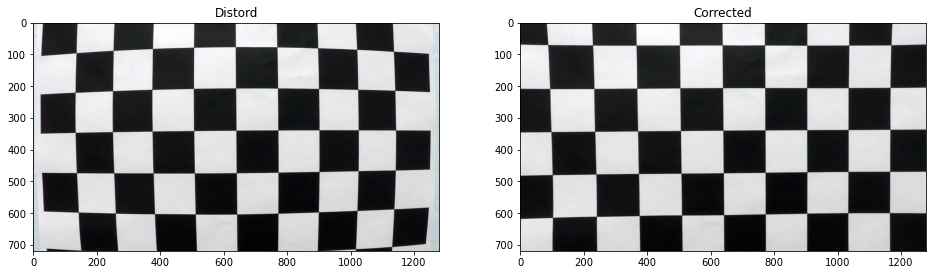

In [4]:
img_distort   = cv2.imread('./camera_calibration/calibration1.jpg')
img_undistort = cv2.undistort(img_distort, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#fig.tight_layout()
ax1.imshow(img_distort);   ax1.set_title("Distord")
ax2.imshow(img_undistort); ax2.set_title("Corrected");

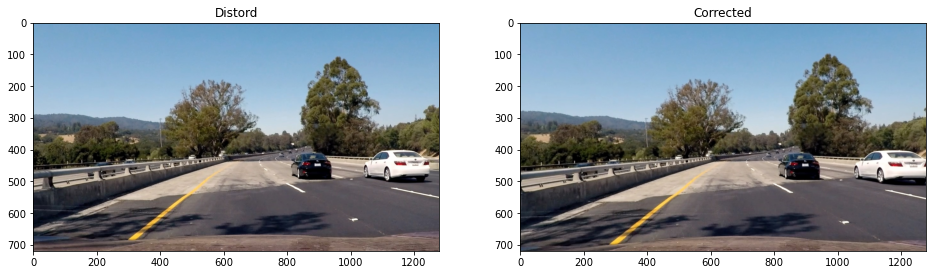

In [5]:
img_distort   = cv2.imread("../dataset_imgs/720_test4.jpg")
img_distort   = cv2.cvtColor(img_distort, cv2.COLOR_BGR2RGB)
img_undistort = cv2.undistort(img_distort, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#fig.tight_layout()
ax1.imshow(img_distort);   ax1.set_title("Distord")
ax2.imshow(img_undistort); ax2.set_title("Corrected");

In [6]:
HEIGHT = img_distort.shape[0]
WIDTH  = img_distort.shape[1]

## 3. Reduce noise

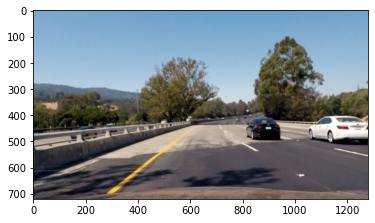

In [7]:
img_blur = cv2.GaussianBlur(img_undistort, (5,5), 0)
plt.imshow(img_blur, cmap='gray');

# Perspective Transformation

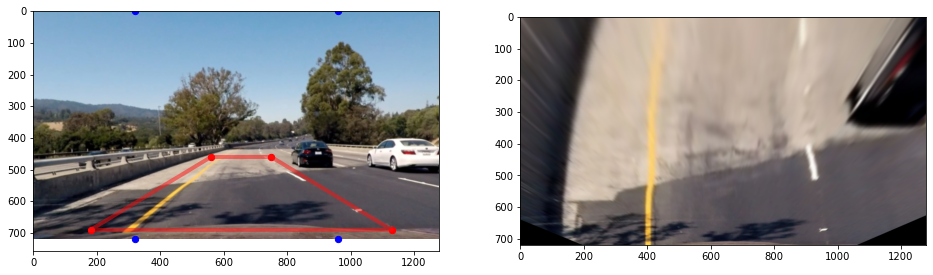

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(img_blur, cmap='gray');

#x = [580, 740, 1100, 270, 580]
#y = [460, 460, 670, 670, 460]

x = [180, 560, 750, 1130, 180]
y = [690, 460, 460, 690, 690]
ax1.plot(x, y, color='#ff1010', alpha=0.5, linewidth=4, solid_capstyle='round', zorder=2)

ax1.scatter(x=[560, 180, 1130, 750], y=[460, 690, 690, 460], c='r', s=40)
ax1.scatter(x=[320, 320, 960, 960], y=[0, 720, 720, 0], c='b', s=40)

################################

src = np.float32([[560,460],[180,690], [1130,690],[750,460]])
dst = np.float32([[320,0],  [320,720], [960,720], [960,0]])

PT     = cv2.getPerspectiveTransform(src, dst)
PT_inv = cv2.getPerspectiveTransform(dst, src)

road_rgb = cv2.warpPerspective(img_blur, PT, (img_blur.shape[1], img_blur.shape[0]), flags=cv2.INTER_LINEAR)


ax2.imshow(road_rgb, cmap='gray');

# RBG, HLS, HSV

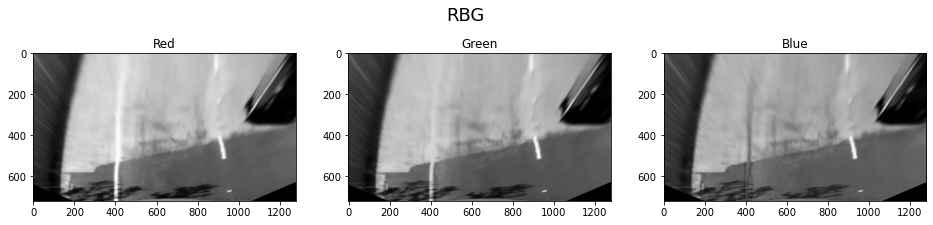

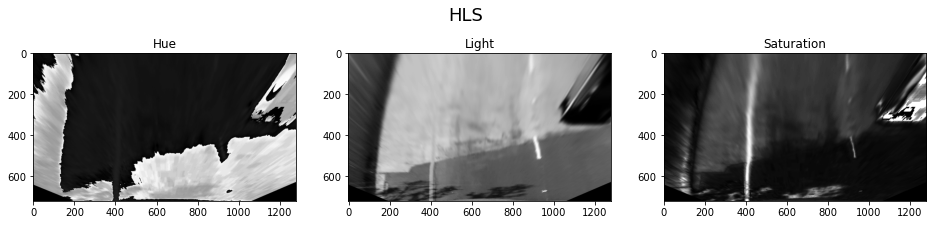

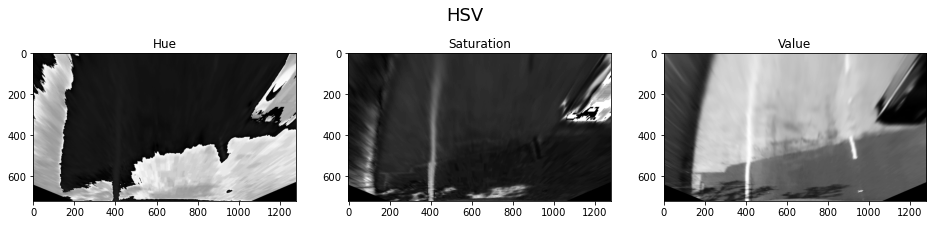

In [9]:
road_hls = cv2.cvtColor(road_rgb, cv2.COLOR_RGB2HLS)
road_hsv = cv2.cvtColor(road_rgb, cv2.COLOR_RGB2HSV)

formats = {
    "RBG": {"img": road_rgb, "ch_names": ['Red', 'Green', 'Blue']},
    "HLS": {"img": road_hls, "ch_names": ['Hue', 'Light', 'Saturation']},
    "HSV": {"img": road_hsv, "ch_names": ['Hue', 'Saturation', 'Value']}
}

for format_name, format_data in formats.items():
    fig, axes = plt.subplots(1, 3, figsize=(16, 3.5))
    fig.suptitle(format_name, fontsize=18)
    
    format_img = format_data["img"]
    format_ch_names = format_data["ch_names"]
    
    for ch_i in range(3):
        axes[ch_i].imshow(format_img[:,:,ch_i], cmap='gray');
        axes[ch_i].set_title(format_ch_names[ch_i], fontsize=12)

# Yellow mask on RGB

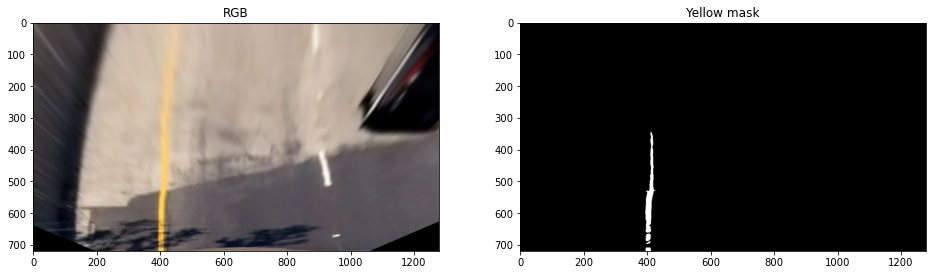

In [10]:
yellow_mask = cv2.inRange(road_rgb, lowerb = np.array([150, 150, 0]),
                                    upperb = np.array([255, 255, 120]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(road_rgb);                 ax1.set_title("RGB")
ax2.imshow(yellow_mask, cmap='gray'); ax2.set_title("Yellow mask");

# White mask on RGB

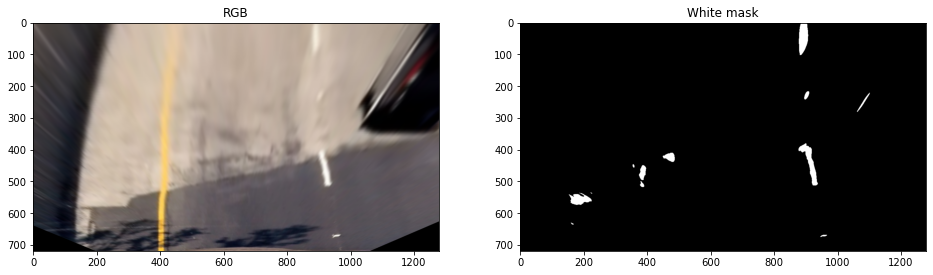

In [11]:
white_mask = cv2.inRange(road_rgb, lowerb = np.array([185, 185, 185]),
                                   upperb = np.array([255, 255, 255]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(road_rgb); ax1.set_title("RGB")
ax2.imshow(white_mask, cmap='gray'); ax2.set_title("White mask");

# HLS saturation mask

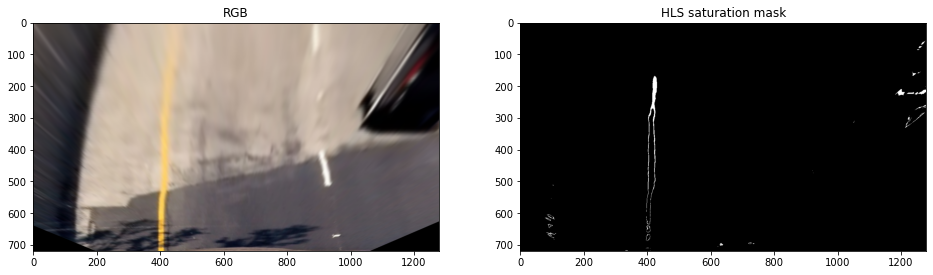

In [12]:
# Convert to HLS color space and isolate the saturation channel
hls_saturation = road_hls[:,:,2]

# Apply the threshold on the hls saturation channel
hls_saturation_mask = np.zeros_like(hls_saturation)
hls_saturation_mask[(hls_saturation >= 180) & (hls_saturation <= 200)] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(road_rgb);                 ax1.set_title("RGB")
ax2.imshow(hls_saturation_mask, cmap='gray'); ax2.set_title("HLS saturation mask");

# HSV value mask

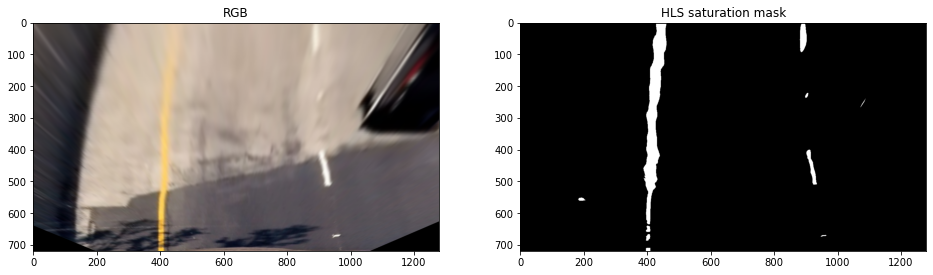

In [13]:
# Convert to HLS color space and isolate the saturation channel
hsv_value = road_hsv[:,:,2]

# Apply the threshold on the hls saturation channel
hsv_value_mask = np.zeros_like(hsv_value)
hsv_value_mask[(hsv_value >= 225) & (hsv_value <= 255)] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(road_rgb);                 ax1.set_title("RGB")
ax2.imshow(hsv_value_mask, cmap='gray'); ax2.set_title("HLS saturation mask");

# Combine 4 binary masks

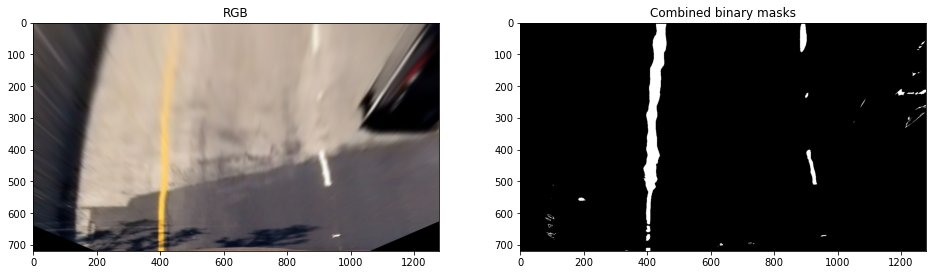

In [14]:
combined_binary = np.zeros_like(white_mask)

combined_binary[(yellow_mask == 1) \
                | (white_mask == 1) \
                | (hls_saturation_mask == 1) \
                | (hsv_value_mask == 1)] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(road_rgb);                 ax1.set_title("RGB")
ax2.imshow(combined_binary, cmap='gray'); ax2.set_title("Combined binary masks");

# Histogram

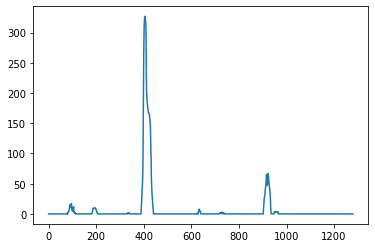

In [15]:
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [16]:
midpoint = len(histogram)//2

left_line_pos  = np.argmax(histogram[:midpoint])
right_line_pos = np.argmax(histogram[midpoint:]) + midpoint

left_line_pos, right_line_pos

(404, 923)

# Windows boxes

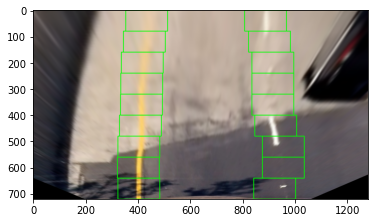

In [17]:
img = combined_binary
out_img = road_rgb.copy()

# Choose the number of sliding windows
num_windows = 9

# Set height of windows
window_height = HEIGHT // num_windows

# Identify the x and y positions of all nonzero pixels in the image
nonzero = img.nonzero()
nonzeroy = nonzero[0]
nonzerox = nonzero[1]

# Current positions to be updated for each window
leftx_current = left_line_pos
rightx_current = right_line_pos

# Set the width of the windows +/- margin
margin = 80

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(window_height):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = img.shape[0] - (window+1)*window_height
    win_y_high = img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low)  & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = int(np.mean(nonzerox[good_right_inds]))
        
plt.imshow(out_img); 

# Fit 2nd order polynomial 

In [18]:
# Concatenate the arrays of indices
left_lane_inds  = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx  = nonzerox[left_lane_inds]
lefty  = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Visualize

(720.0, 0.0)

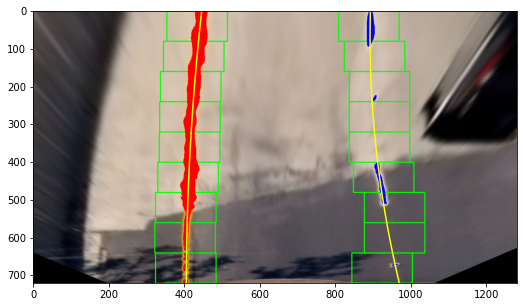

In [19]:
ploty = np.linspace(0, HEIGHT-1, HEIGHT)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize = (10,5))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Drawing Lane Lines in Original Image

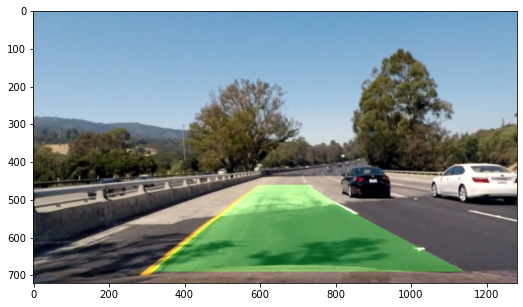

In [20]:
def draw_lines(original_img, binary_img, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    
    return result
    
new_img = draw_lines(img_blur, combined_binary, left_fit, right_fit, PT_inv)
plt.figure(figsize = (10,5))
plt.imshow(new_img);